In [1]:
from numpy import where
from os.path import join
from pickle import dump
from skimage.io import imread
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import minimum_filter1d

In [53]:
def convert_img_to_mask(img):
        return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

In [54]:
data_dir = "01_input/"

In [55]:
img = imread(join(data_dir, 'img.png'))
mask = convert_img_to_mask(imread(join(data_dir, 'mask.png')))

In [56]:
print(img.shape)

(475, 700, 3)


In [68]:
print(np.transpose(img, (1, 0, 2)).shape)


(700, 475, 3)


In [6]:
print(mask.shape)

(475, 700)


In [7]:
h, w, c = img.shape

In [45]:
def get_img_y(img):
    img_y = []
    for row in img:
        row_y = []
        for pixel in row:
            r, g, b = pixel
            y = 0.299 * r + 0.587 * g + 0.114 * b
            row_y.append(y)
        img_y.append(row_y)
    return np.asarray(img_y)

In [46]:
img_y = get_img_y(img)

In [47]:
print(img_y.shape)

(475, 700)


In [48]:
def get_grad_x(img):
    h, w = img.shape
    grad_x = []
    for row in img:
        grad_x_row = row[:-2] - row[2:]
        grad_x_row = [row[0] - row[1]] + list(grad_x_row) + [row[-2] - row[-1]]
        grad_x.append(grad_x_row)
    return np.asarray(grad_x)

In [49]:
def get_grad(img, mask):
    h, w = img.shape
    grad_x = get_grad_x(img)
    grad_y = get_grad_x(img.T).T
    grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
    if mask is not None:
        grad = grad + mask * max(h, w) * 64
    return grad

In [13]:
img_y_grad = get_grad(img_y)

In [50]:
def find_carve_vertical(img_energies):
    h, w = img_energies.shape
    carves = [[-1 for j in range(w)] for i in range(h)]
    acc_energies = [[0 for j in range(w)] for i in range(h)]
    for i in range(w):
        carves[0][i] = i
        acc_energies[0][i] = img_energies[0][i]
    
    for i in range(1, h):
        for j in range(w):
            neigs = []
            if j - 1 >= 0:
                neigs.append(j - 1)
            neigs.append(j)
            if j + 1 <= w - 1:
                neigs.append(j + 1)
                
            mmin = 10000000
            for k in range(len(neigs)):
                if acc_energies[i - 1][neigs[k]] < mmin:
                    mmin = acc_energies[i - 1][neigs[k]]
                    carves[i][j] = neigs[k]
                    acc_energies[i][j] = mmin + img_energies[i][j]
    
    final_index = np.argmin(acc_energies[h - 1])
    carve = [(h - 1, final_index)]
    for i in range(h - 1, 0, -1):
        final_index = carves[i][final_index]
        carve.append((i - 1, final_index))
    
    return list(reversed(carve))

In [15]:
carve = find_carve_vertical(img_y_grad)

In [51]:
def get_img_carved(img, carve):
    h, w, c = img.shape
    
    new_img = []
    for i in range(h):
        new_row = img[i].copy()
        new_row = np.delete(new_row, carve[i][1], 0)
        new_img.append(new_row)
    return np.asarray(new_img)

In [25]:
def get_mask_carved(mask, carve):
    h, w = mask.shape
    
    new_mask = []
    for i in range(h):
        new_row = mask[i].copy()
        new_row = np.delete(new_row, carve[i][1])
        new_mask.append(new_row)
    return np.asarray(new_mask)

In [17]:
def get_img_carve(img, carve):
    h, w, c = img.shape
    
    new_img = []
    for i in range(h):
        new_row = np.zeros(w)
        new_row[carve[i][1]] = 1
        new_img.append(new_row)
    return np.asarray(new_img)

In [52]:
def seam_carve(img, mode, mask):
    if mode.find("vertical") != -1:
        img = img.T
        if mask is not None:
            mask = mask.T
    img_y = get_img_y(img)
    img_y_grad = get_grad(img_y, mask)
    carve = find_carve_vertical(img_y_grad)
    new_img = get_img_carved(img, carve)
    new_mask = None
    if mask is not None:
        new_mask = get_mask_carved(mask, carve)
    img_carve = get_img_carve(img, carve)
    if mode.find("vertical") != -1:
        new_img = new_img.T
        if new_mask is not None:
            new_mask = new_mask.T
        img_carve = img_carve.T
    return new_img, new_mask, img_carve

In [40]:
new_img, new_mask, img_carve = seam_carve(img, None, None)

In [41]:
print(img_carve.shape)
h, w = img_carve.shape

(475, 700)


/home/nimloth/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


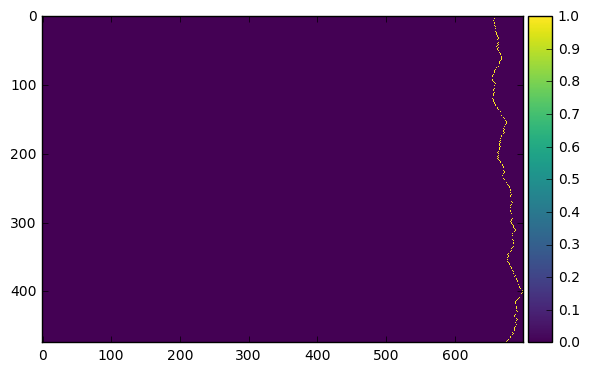

In [42]:
imshow(img_carve)
plt.show()

In [37]:
for i in range(h):
    if sum(img_carve[i]) != 1:
        print("bug")